In [1]:
# GPU Server not working #I tried using only what I have. Thus, I did not use full dataset to run the model
import csv
import math
from tensorflow import keras

import cv2
import numpy as np
from keras import Model
from keras.applications import MobileNetV2
from keras.applications.resnet50 import preprocess_input
from keras.layers import MaxPooling2D, Conv2D, Reshape, Dense, Flatten
import tensorflow as tf
from keras.datasets import cifar10
import sys
import matplotlib.pyplot as plt

# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="x"


### Import Dataset

In [2]:
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
print ('Training data size:', train_images.shape, 'Test data size', test_images.shape)

# Normalize pixel values between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

Training data size: (50000, 32, 32, 3) Test data size (10000, 32, 32, 3)


### Visualize dataset

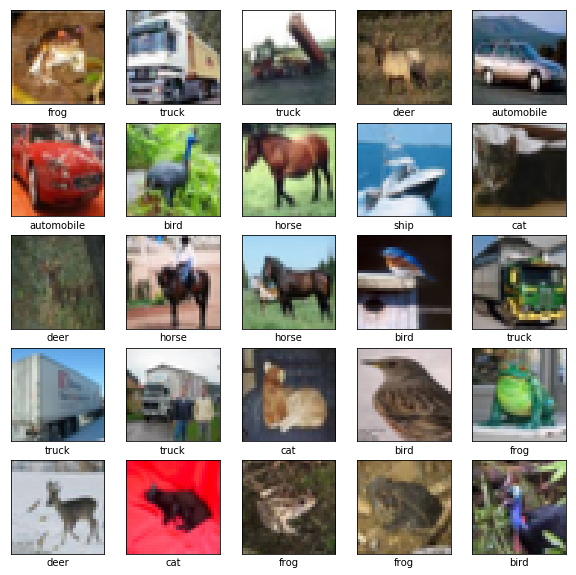

In [3]:
%matplotlib inline
#Show first 25 training images below
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

### Split Train Images into 5 Batches of Images

In [4]:
#Only chose batch 1 for analysis due to computational lack of resource
train_batch1 = train_images[0:10000]
# train_batch2 = train_images[10000:20000]
# train_batch3 = train_images[20000:30000]
# train_batch4 = train_images[30000:40000]
# train_batch5 = train_images[40000:50000]

### Resize images for use with MobileNetV2

In [5]:
# Upsize all training and testing images to 96x96 for use with mobile net
minSize = 96 #minimum size requried for mobileNet
#<Write code> You may use cv2 package. Look for function:
"cv2.resize(<originalImage>, dsize=(minSize, minSize), interpolation=cv2.INTER_CUBIC)"


'cv2.resize(<originalImage>, dsize=(minSize, minSize), interpolation=cv2.INTER_CUBIC)'

In [6]:
# Function for resizing
def resizing(data):
  resized_images = np.empty((data.shape[0], minSize, minSize, data.shape[3]), dtype=data.dtype)
  for i in range(data.shape[0]):
      #img = cv2.imread(image)
      resized_images[i] = cv2.resize(np.copy(data[i]), dsize=(minSize, minSize), interpolation=cv2.INTER_CUBIC)
  return resized_images   

In [7]:
resized_train_batch1 = resizing(train_batch1)

In [8]:
resized_test_batch = resizing(test_images)

### Data Augmentation

In [9]:
#Did this as my data size used for training is not large enough #Applying transformations to the training images, such as rotation and horizontal flipping
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Download MobileNetV2 model



In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3),
                                               include_top=False, # exclude classification layers at the top
                                               weights='imagenet')

### Feature Extractor

In [11]:
#Feature extraction - convert 32 x 32 x 3 image to 3 x3 x1280 block of features
feature_batch = base_model(resized_train_batch1[:500])

In [12]:
print(feature_batch.shape)

(500, 3, 3, 1280)


### Freezing Convolutional Base

In [13]:
#Freezing convolutional base
base_model.trainable = False #prevents the weights in a given layer from being updated during training

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

## Add custom layers at the end of downloaded model

### Adding an Output Layer

In [16]:
# convert thee features into a single prediction per image
output_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax) #10 classes output layer
prediction_batch = output_layer(feature_batch_avg)
print(prediction_batch.shape)

(500, 10)


### Building the Model

In [17]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False) # beware of batch normalization layer
x = tf.keras.layers.Conv2D(1280, 2, activation=tf.nn.relu, input_shape = (96, 96, 3))(x)# one hidden layer  #edit this
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

### Add loss function, train the model, and check accuracy on test data

In [18]:

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 1280)        6554880   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 1280)        0         
_________________________________________________________________
dense (Dense)                (None, 1, 1, 10)          12810     
Total params: 8,825,674
Trainable params: 6,567,690
Non-trainable params: 2,257,984
____________________________________

In [21]:
epochs = 8
history = model.fit(resized_train_batch1[:500], train_labels[:500], epochs=epochs)

Epoch 1/8
16/16 [==============================] - 7s 454ms/step - loss: 2.7819 - accuracy: 0.0945
Epoch 2/8
16/16 [==============================] - 7s 454ms/step - loss: 1.7224 - accuracy: 0.1125
Epoch 3/8
16/16 [==============================] - 7s 420ms/step - loss: 1.3834 - accuracy: 0.1141
Epoch 4/8
16/16 [==============================] - 7s 423ms/step - loss: 1.2072 - accuracy: 0.1180
Epoch 5/8
16/16 [==============================] - 7s 416ms/step - loss: 1.1122 - accuracy: 0.1207
Epoch 6/8
16/16 [==============================] - 7s 419ms/step - loss: 1.0945 - accuracy: 0.1173
Epoch 7/8
16/16 [==============================] - 7s 452ms/step - loss: 0.8938 - accuracy: 0.1201
Epoch 8/8
16/16 [==============================] - 8s 482ms/step - loss: 0.8644 - accuracy: 0.1159


In [22]:
history.history

{'loss': [2.781851053237915,
  1.7223514318466187,
  1.3834370374679565,
  1.2071505784988403,
  1.1121997833251953,
  1.0944818258285522,
  0.8937972784042358,
  0.8644371628761292],
 'accuracy': [0.09447969496250153,
  0.11249999701976776,
  0.11408629268407822,
  0.11795685440301895,
  0.12068527936935425,
  0.11725888401269913,
  0.12011421471834183,
  0.11586294323205948]}

In [23]:
#Checking accuracy on test data
test_loss, test_acc = model.evaluate(resized_test_batch[:500], test_labels[:500])
print('Test accuracy:', test_acc)

16/16 [==============================] - 3s 170ms/step - loss: 1.7420 - accuracy: 0.1089
Test accuracy: 0.10894670337438583


### Extra code for producing different plots, accuracy values

Text(0.5,1,'Accuracy vs Epoch Number')

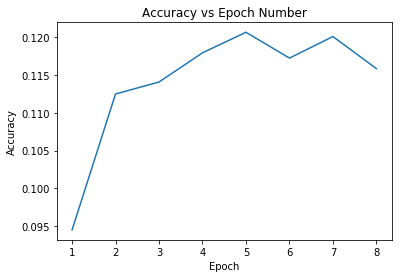

In [30]:
acc = history.history['accuracy']

loss = history.history['loss']

fig,ax = plt.subplots(1)

x = list(range(1, epochs+1))
y = acc

# plot the data
ax.plot(x,y)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy vs Epoch Number')

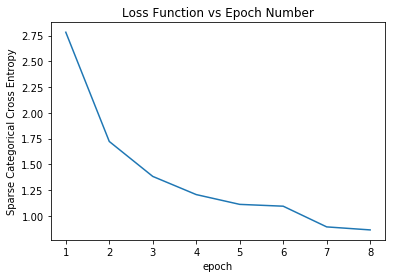

In [29]:
# plt.subplot(2, 1, 2)
fig,ax = plt.subplots(1)

# plt.plot(loss, label='Training Loss')
x = list(range(1, epochs+1))
y = loss
ax.plot(x,y)
plt.ylabel('Sparse Categorical Cross Entropy')

plt.title('Loss Function vs Epoch Number')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Compile the model with appropriate Loss function
#<Write code>

In [ ]:
#<Write code>